In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

# Prepare data

In [2]:
import os

train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
feature_names = column_names[:-1]
label_name = column_names[-1]

batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

train_dataset = train_dataset.map(pack_features_vector)

In [3]:
y = np.concatenate([y for x, y in train_dataset], axis=0)
x = np.concatenate([x for x, y in train_dataset], axis=0)

In [4]:
n = x.shape[0]
n_train = int(0.8*n)
n_val = n-n_train

x_val = x[n_train:]
y_val = y[n_train:]

x = x[:n_train]
y = y[:n_train]

# Create model

In [2]:
from evolvepy.integrations.tf_keras import EvolutionaryModel

def create_model():
    model = EvolutionaryModel([keras.layers.Dense(10, activation="relu", input_shape=(4,)),
                                keras.layers.Dense(10, activation="relu"),
                                keras.layers.Dense(3)])
    return model

model = create_model()

In [3]:
model.weights[0].name

'dense/kernel:0'

# Prepare generator

In [6]:
import evolvepy as ep
from evolvepy.integrations.tf_keras.tf_keras import get_descriptor


def create_generator(model):
    descriptor = get_descriptor(model)
    first = ep.generator.Layer()
    combine = ep.generator.CombineLayer(ep.generator.selection.tournament, ep.generator.crossover.one_point)
    mutation = ep.generator.mutation.NumericMutationLayer(ep.generator.mutation.sum_mutation, 1.0, 0.5, (-0.5, 0.5))
    filter0 = ep.generator.FilterFirsts(143)
    sort = ep.generator.Sort()
    filter1 = ep.generator.FilterFirsts(7)
    concat = ep.generator.Concatenate()

    first.next = combine
    combine.next = mutation
    combine.next = filter0
    filter0.next = concat

    first.next = sort
    sort.next = filter1
    filter1.next = concat

    generator = ep.generator.Generator(first_layer=first, last_layer=concat, descriptor=descriptor)

    return generator, mutation.name

generator, mut_name = create_generator(model)

# Mode 1

In [34]:
from evolvepy.integrations.tf_keras import TFKerasEvaluator, LossFitnessFunction

fitness_function = LossFitnessFunction(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), x=x, y=y)
evaluator = TFKerasEvaluator(model, fitness_function)

In [35]:
generator, mut_name = create_generator(model)

mem_log1 = ep.callbacks.MemoryStoreLogger(log_population=True)
dyn_mut = ep.callbacks.DynamicMutation([mut_name], patience=2, refinement_steps=20, refinement_patience=2, exploration_steps=10, exploration_patience=2, refinement_divider=3)

evolver = ep.Evolver(generator, evaluator, 150, [mem_log1, dyn_mut])

In [36]:
hist1, last_pop = evolver.evolve(100)

# Modo 2

In [133]:
model = create_model()

In [134]:
from evolvepy.callbacks import MemoryStoreLogger

generator, mut_name = create_generator(model)

mem_log4 = ep.callbacks.MemoryStoreLogger(log_population=True)
dyn_mut = ep.callbacks.DynamicMutation([mut_name], patience=2, refinement_steps=20, refinement_patience=2, exploration_steps=10, exploration_patience=2, refinement_divider=3)

model.compile(generator, 150, [mem_log4], loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [12]:
hist2 = model.fit(x, y, validation_data=(x_val, y_val), epochs = 100, steps_per_epoch=1)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 1.1162 - accuracy: 0.3854 - val_loss: 1.0756 - val_accuracy: 0.3750
Epoch 2/100
1/1 [==============================] - 1s 908ms/step - loss: 1.1162 - accuracy: 0.3854 - val_loss: 1.0756 - val_accuracy: 0.3750
Epoch 3/100
1/1 [==============================] - 1s 958ms/step - loss: 1.1162 - accuracy: 0.3854 - val_loss: 1.0756 - val_accuracy: 0.3750
Epoch 4/100
1/1 [==============================] - 1s 886ms/step - loss: 1.0968 - accuracy: 0.3854 - val_loss: 1.1209 - val_accuracy: 0.2917
Epoch 5/100
1/1 [==============================] - 1s 938ms/step - loss: 1.0968 - accuracy: 0.3854 - val_loss: 1.1209 - val_accuracy: 0.2917
Epoch 6/100
1/1 [==============================] - 1s 929ms/step - loss: 1.0968 - accuracy: 0.3854 - val_loss: 1.1209 - val_accuracy: 0.2917
Epoch 7/100
1/1 [==============================] - 1s 890ms/step - loss: 1.0968 - accuracy: 0.3854 - val_loss: 1.1209 - val_accuracy: 0.2917
Epoch 8/100
1/1 

In [135]:
hist4 = model.fit(x, y, validation_data=(x_val, y_val), epochs = 100, batch_size=24)

Epoch 1/100
4/4 [==============================] - 5s 1s/step - loss: 0.9876 - accuracy: 0.4688 - val_loss: 1.2387 - val_accuracy: 0.2500
Epoch 2/100
4/4 [==============================] - 4s 962ms/step - loss: 1.0736 - accuracy: 0.3854 - val_loss: 1.0930 - val_accuracy: 0.2500
Epoch 3/100
4/4 [==============================] - 4s 1s/step - loss: 1.0654 - accuracy: 0.4167 - val_loss: 1.1923 - val_accuracy: 0.2500
Epoch 4/100
4/4 [==============================] - 4s 1s/step - loss: 0.9719 - accuracy: 0.4167 - val_loss: 1.1350 - val_accuracy: 0.3750
Epoch 5/100
4/4 [==============================] - 4s 1s/step - loss: 1.0562 - accuracy: 0.4896 - val_loss: 1.0816 - val_accuracy: 0.4167
Epoch 6/100
4/4 [==============================] - 5s 1s/step - loss: 1.0651 - accuracy: 0.4583 - val_loss: 1.0666 - val_accuracy: 0.4583
Epoch 7/100
4/4 [==============================] - 5s 1s/step - loss: 0.9110 - accuracy: 0.4479 - val_loss: 1.3040 - val_accuracy: 0.2500
Epoch 8/100
4/4 [==============

In [37]:
fitness1 = hist1
fitness2 = []

for log in mem_log2.log:
    fitness2.append(log["fitness"])

fitness2 = np.array(fitness2)

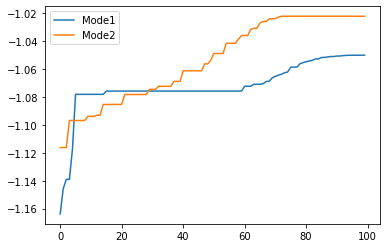

In [38]:
from matplotlib import pyplot as plt

plt.plot(np.max(fitness1, axis=1))
plt.plot(np.max(fitness2, axis=1))

plt.legend(["Mode1", "Mode2"])

plt.show()


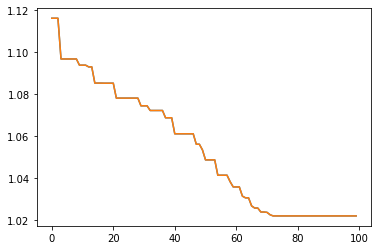

In [39]:
plt.plot(-np.max(fitness2, axis=1))
plt.plot(hist2.history["loss"])

In [47]:
from evolvepy.integrations.tf_keras import transfer_weights

val_loss1 = []

model = evaluator._model

for i in range(100):
    best = mem_log1.log[i]["population"][np.argmax(hist1[i])]
    transfer_weights(best, model)
    val_loss1.append(model.evaluate(x_val, y_val, verbose=0)[0])


In [61]:
model_tf = keras.Sequential([keras.layers.Dense(10, activation="relu", input_shape=(4,)),
                                keras.layers.Dense(10, activation="relu"),
                                keras.layers.Dense(3)])

model_tf.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))
hist_tf = model_tf.fit(x, y, steps_per_epoch=1, epochs=100, verbose=0, validation_data=(x_val, y_val))

In [137]:
fitness4 = []

for log in mem_log4.log:
    fitness4.append(log["best_fitness"])

fitness4 = np.array(fitness4)

In [111]:
model.compiled_loss

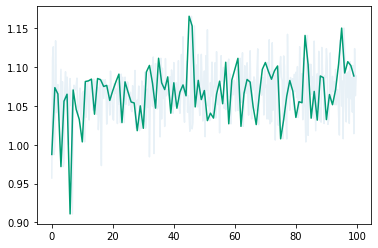

In [138]:
plt.plot(hist4.history["loss"], color="#009E73")
plt.plot(np.arange(0,100, 0.25), -fitness4, alpha=0.1)

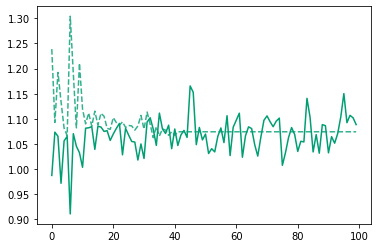

In [139]:
plt.plot(hist4.history["loss"], color="#009E73")
plt.plot(hist4.history["val_loss"], "--", color="#009E73", alpha=0.8)

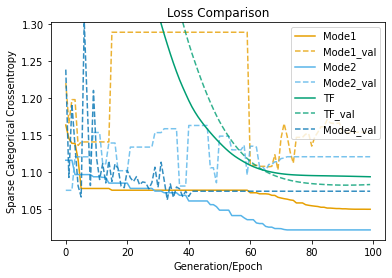

In [143]:
plt.plot(-hist1.max(axis=1), color="#E69F00")
plt.plot(val_loss1, "--", color="#E69F00", alpha=0.8)

plt.plot(hist2.history["loss"], color="#56B4E9")
plt.plot(hist2.history["val_loss"], "--", color="#56B4E9", alpha=0.8)

plt.ylim(plt.ylim())

plt.plot(hist_tf.history["loss"], color="#009E73")
plt.plot(hist_tf.history["val_loss"], "--", color="#009E73", alpha=0.8)

plt.plot(hist4.history["val_loss"], "--", color="#0072B2", alpha=0.8)

plt.legend(["Mode1", "Mode1_val", "Mode2", "Mode2_val", "TF", "TF_val", "Mode4_val"])
plt.title("Loss Comparison")
plt.xlabel("Generation/Epoch")
plt.ylabel("Sparse Categorical Crossentropy")
plt.savefig("Loss Comparison.jpg")

plt.show()

In [53]:
%timeit evolver.evolve(1)

541 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
%timeit model.fit(x, y, steps_per_epoch=1, verbose=0)

935 ms ± 40.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
%timeit model_tf.fit(x, y, steps_per_epoch=1, verbose=0)

34.9 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Times

Mode | Time
-|-
Mode 1 | 541 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mode 2 | 935 ms ± 40.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
TF | 34.9 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)